<a href="https://colab.research.google.com/github/unknown-jun/NLP_study/blob/main/NLP_Book/B04_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

class RNN:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_prev):
    Wx, Wh, b = self.params
    t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
    h_next = np.tanh(t)

    self.cache = (x, h_prev, h_next)
    return h_next

  def backward(self, dh_next):
    Wx, Wh, b = self.params
    x, h_prev, h_next = self.caceh
    
    dt = dh_next * (1-h_next ** 2)
    db = np.sum(dt, axis=0)
    dWh = np.dot(h_prev.T, dt)
    dh_prev = np.dot(dt, Wh.T)
    dWx = np.dot(x.T, dt)
    dx = np.dot(dt, Wx.T)

    self.grads[0][...] = dWx
    self.gards[1][...] = dWh
    self.gards[2][...] = db

    return dx, dh_prev

# MNIST 데이터셋

In [ ]:
import math  # 수학과 관련되어 다양한 함수들과 상수들이 정의되어 있는 라이브러리
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import Parameter  # 파라미터 목록을 갖고 있는 라이브러리(패키지)
from torch import Tensor
from tqdm import notebook

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(125)

In [ ]:
# 데이터 전처리
mnist_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,),(1.0,))  # 평균을 0.5, 표준편차를 1.0으로 데이터 정규화(데이터 분포 조정)
])

In [ ]:
# 데이터셋 내려받기
from torchvision.datasets import MNIST
download_root = './MNIST_DATASET'

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



In [ ]:
# 데이터셋을 메모리로 가져오기

batch_size=64
train_loader = DataLoader(dataset= train_dataset,
                          batch_size= batch_size,
                          shuffle=True)
valid_loader = DataLoader(dataset= test_dataset,
                          batch_size= batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset= test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

In [ ]:
# 변수 값 지정

batch_size= 100
n_iters= 6000
num_epochs= n_iters / (len(train_dataset) / batch_size)
num_epochs= int(num_epochs)

In [ ]:
# LSTM 셀 네트워크 구축
class LSTMCell(nn.Module):
  def __init__(self, input_size, hidden_size, bias=True):
    super(LSTMCell, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=bias)
    self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)
    self.reset_parameters()

  def reset_parameters(self):    # 모델의 파라미터 초기화
    std = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-std, std)

  def forward(self, x, hidden):
    hx, cx = hidden
    x = x.view(-1, x.size(1))

    gates = self.x2h(x) + self.h2h(hx)
    gates = gates.squeeze()
    ingate, forgetgate, cellgate, outgate = gates.chunk(4,1)

    ingate = F.sigmoid(ingate)
    forgetgate = F.sigmoid(forgetgate)
    cellgate = F.tanh(cellgate)
    outgate = F.sigmoid(outgate)

    cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
    hy = torch.mul(outgate, F.tanh(cy))
    return (hy, cy)

In [ ]:
# LSTM 셀의 전반적인 네트워크
class LSTMModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
    super(LSTMModel, self).__init__()
    self.hidden_dim = hidden_dim   # 은닉층의 뉴런/유닛 개수

    self.layer_dim = layer_dim
    self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    if torch.cuda.is_available():
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
      # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 형태를 갖는 은닉 상태를 0으로 초기화
    else:
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

    if torch.cuda.is_available():
      c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
      # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 형태를 갖는 은닉 상태를 0으로 초기화
    else:
      c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

    outs = []
    cn = c0[0,:,:]     # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 크기를 갖는 셀 상태에 대한 텐서
    hn = h0[0,:,:]     # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 크기를 갖는 은닉 상태에 대한 텐서

    for seq in range(x.size(1)):        # LSTM 셀 계층을 반복하여 쌓아 올림
      hn, cn = self.lstm(x[:, seq, :], (hn, cn))  # 은닉 상태(hn)와 셀 상태를 LSTMCell에 적용한 결과에 또다시 hn, cn에 저장
      outs.append(hn)

    out = outs[-1].squeeze()
    out = self.fc(out)
    return out

In [ ]:
# 옵티마이저와 손실 함수 지정
input_dim = 28
hidden_dim= 128
layer_dim = 1
output_dim= 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
if torch.cuda.is_available():
  model.cuda()

learning_rate = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# 모델 학습 및 성능 확인
seq_dim = 28
loss_list = []
iter = 0

for epoch in notebook.tqdm(range(num_epochs)):
  for i, (images, labels) in enumerate(train_loader):      # 훈련 데이터셋을 이용한 모델 학습
    if torch.cuda.is_available():
      images = Variable(images.view(-1, seq_dim, input_dim).cuda())
      labels = Variable(labels.cuda())
    else:
      images = Variable(images.view(-1, seq_dim, input_dim))
      labels = Variable(labels)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)  # 손실 함수를 이용하여 오차 계산

    if torch.cuda.is_available():
      loss.cuda()

    loss.backward()
    optimizer.step()      # 파라미터 업데이트
    loss_list.append(loss.item())
    iter += 1

    if iter % 500 == 0:   # 정확도 계산
      correct = 0
      total = 0
      for images, labels in valid_loader:    # 검증 데이터셋을 이용한 모델 성능 검증

        if torch.cuda.is_available():
          images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else:
          images = Variable(images.view(-1, seq_dim, input_dim))

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # 모델을 통과한 결과의 최댓값으로부터 예측 결과 가져오기

        total += labels.size(0)  # 총 레이블 수
        if torch.cuda.is_available():
          correct += (predicted.cpu() == labels.cpu()).sum()
        else:
          correct += (predicted == labels).sum()

      accuracy = 100 * correct / total
      print('Iteration: {}, Loss: {}, Accuracy: {}'.format(iter, loss.item(), accuracy))

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iteration: 500, Loss: 2.237457275390625, Accuracy: 21.420000076293945
Iteration: 1000, Loss: 1.3316558599472046, Accuracy: 68.26000213623047
Iteration: 1500, Loss: 0.43492987751960754, Accuracy: 89.73999786376953
Iteration: 2000, Loss: 0.264164000749588, Accuracy: 92.8499984741211
Iteration: 2500, Loss: 0.057534582912921906, Accuracy: 95.81999969482422
Iteration: 3000, Loss: 0.08736630529165268, Accuracy: 95.5199966430664
Iteration: 3500, Loss: 0.06809159368276596, Accuracy: 96.29000091552734
Iteration: 4000, Loss: 0.07597149163484573, Accuracy: 96.19000244140625
Iteration: 4500, Loss: 0.07629992812871933, Accuracy: 96.8499984741211
Iteration: 5000, Loss: 0.07461799681186676, Accuracy: 97.05999755859375
Iteration: 5500, Loss: 0.10998763889074326, Accuracy: 97.08999633789062
Iteration: 6000, Loss: 0.021271005272865295, Accuracy: 97.44999694824219
Iteration: 6500, Loss: 0.01609448343515396, Accuracy: 97.55999755859375
Iteration: 7000, Loss: 0.022666366770863533, Accuracy: 97.690002441406

In [ ]:
# 테스트 데이터셋을 이용한 모델 예측 성능 확인
def evaluate(model, val_iter):
  corrects, total, total_loss = 0,0,0
  model.eval()
  for images, labels in val_iter:
    if torch.cuda.is_available():
      images = Variable(images.view(-1, seq_dim, input_dim).cuda())
    else:
      images = Variable(images.view(-1, seq_dim, input_dim))

    logit = model(images).to(device)
    labels= labels.to(device)
    
    loss = F.cross_entropy(logit, labels, reduction='sum')  # reduction='sum'을 지정했기 때문에 모든 오차를 더함
    _, predicted = torch.max(logit.data,1)  # logit.data 텐서에서 최댓값의 인덱스(index)를 반환
    total += labels.size(0)
    total_loss += loss.item()
    corrects += (predicted == labels).sum()

  avg_loss = total_loss / len(val_iter.dataset)
  avg_accuracy = corrects / total
  return avg_loss, avg_accuracy

In [ ]:
test_loss, test_acc = evaluate(model,test_loader)
print("Test Loss: %5.2f | Test Accuracy: %5.2f" % (test_loss, test_acc))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Test Loss:  0.07 | Test Accuracy:  0.98


# 스타벅스 주가 데이터

In [ ]:
import os 
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 데이터셋 가져오기
data = pd.read_html('https://github.com/gilbutITbook/080289/blob/main/chap07/data/SBUX.csv')[0].drop('Unnamed: 0', axis=1)
print(data.dtypes)
data.head()

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-11,86.260002,86.870003,85.849998,86.589996,84.145752,4921900
1,2019-12-12,88.000000,88.889999,87.540001,88.209999,85.720032,10282100
2,2019-12-13,88.019997,88.790001,87.580002,88.669998,86.167046,6714100
3,2019-12-16,89.139999,89.300003,88.430000,88.779999,86.273941,6705600
4,2019-12-17,88.870003,88.970001,87.470001,88.129997,85.642288,7296900


In [ ]:
# 날짜 칼럼을 인덱스로 사용
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# 데이터 형식 변경
data['Volume'] = data['Volume'].astype(float)

In [ ]:
# 훈련과 레이블 분리
X = data.iloc[:,:-1]
y = data.iloc[:,5:6]

In [ ]:
# 데이터 분포 조정
ms = MinMaxScaler()    # 데이터의 모든 값이 0~1 사이에 존재하도록 분산 조정
ss = StandardScaler()  # 데이터가 평균 0, 분산 1이 되도록 분산 조정

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200,:]  # 훈련 데이터셋
X_test = X_ss[200:, :]  # 테스트 데이터셋

y_train = y_ms[:200,:]
y_test = y_ms[200:,:]

print('Training Shape', X_train.shape, y_train.shape)
print('Testing Shape', X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [ ]:
# 데이터셋의 형태 및 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train))  # Variable로 감싸진 텐서는 .backward()가 호출될 때 자동으로 기울기가 계산
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

#### 훈련 데이터셋의 형태(200,5)를 (200,1,5)로 변경 ####
X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print('Testing Shape', X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [ ]:
# LSTM 네트워크
class LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM, self).__init__()
    self.num_classes = num_classes  # 클래스의 개수
    self.num_layers = num_layers    # LSTM 계층의 개수
    self.input_size = input_size    # 입력 크기로 훈련 데이터셋의 컬럼 개수를 의미
    self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
    self.seq_length = seq_length    # 시퀀스 길이

    self.lstm = nn.LSTM(input_size=input_size, 
                        hidden_size=hidden_size, 
                        num_layers=num_layers, 
                        batch_first=True)   # LSTM 계층
    self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
    self.fc = nn.Linear(128, num_classes)   # 출력층
    self.relu = nn.ReLU()

  def forward(self, x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))  # 은닉 상태를 0으로 초기화
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))  # 셀 상태를 0으로 초기화
    output, (hn, cn) = self.lstm(x, (h_0, c_0))   # LSTM 계층에 은닉 상태와 셀 상태 적용
    hn = hn.view(-1, self.hidden_size)          # 완전연결층 적용을 위해 데이터의 형태 조정(1차원으로 조정)

    out = self.relu(hn)
    out = self.fc_1(out)
    out = self.relu(out)
    out = self.fc(out)
    return out

In [ ]:
# 변수 값 설정
num_epochs = 1000       # 1000번의 에포크
learning_rate = 0.0001  # 학습률은 0.0001로 지정

input_size = 5      # 입력 데이터셋의 칼럼(feature) 개수
hidden_size = 2     # 은닉층의 뉴런/유닛 개수
num_layers = 1      # LSTM 계층의 개수

num_classes = 1     # 클래스의 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# 모델 학습
for epoch in notebook.tqdm(range(num_epochs)):
  outputs = model.forward(X_train_tensors_f)
  optimizer.zero_grad()
  loss = criterion(outputs, y_train_tensors)
  loss.backward()

  optimizer.step()

  if epoch % 100 == 0:
    print('Epoch: %d, Loss: %1.5f' % (epoch, loss.item()))

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.11021
Epoch: 100, Loss: 0.04034
Epoch: 200, Loss: 0.03776
Epoch: 300, Loss: 0.03642
Epoch: 400, Loss: 0.03487
Epoch: 500, Loss: 0.03348
Epoch: 600, Loss: 0.03218
Epoch: 700, Loss: 0.03097
Epoch: 800, Loss: 0.02971
Epoch: 900, Loss: 0.02836


In [ ]:
# 모델 예측 결과를 출력하기 위한 데이터 크기 재구성
df_x_ss = ss.transform(data.iloc[:,:-1])
df_y_ms = ms.transform(data.iloc[:,-1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))

df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

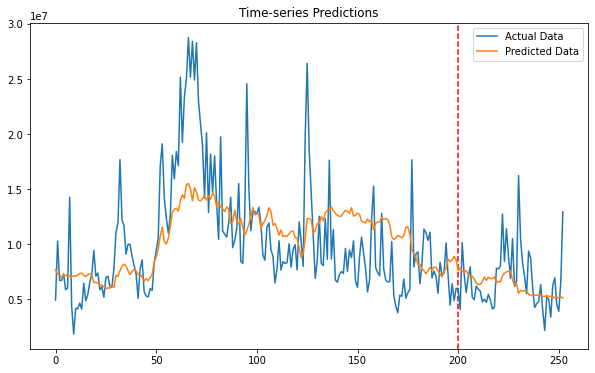

In [ ]:
# 모델 예측 결과 출력
train_predict = model(df_x_ss)  # 훈련 데이터셋을 모델에 적용하여 모델 학습
predicted = train_predict.data.numpy()  # 모델 학습 결과를 넘파이로 변경
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)  # 모델 학습을 위해 전처리(정규화)했던 것을 해제(그래프의 본래 값을 출력하기 위한 목적)
label_y = ms.inverse_transform(label_y)

plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-series Predictions')
plt.legend();